In [1]:
import torch
from torch import nn

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()
        
        # define the model
        self.model = nn.Sequential(
            # Transpose block 1
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            # Transpose block 2
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            # Transpose block 3
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 4
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Last transpose block (different)
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)


In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()
        
        # define the model
        self.model = nn.Sequential(
            # define the first Conv block
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Conv block 2 
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
    
            # Conv block 3
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            # Conv block 4
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            # Conv block 5 (different)
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [4]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [5]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
IMAGE_SIZE = 64
EPOCHS = 1
image_channels = 1
noise_channels = 256
gen_features = 64
disc_features = 64

In [6]:
device = torch.device("cuda")

In [7]:
data_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
])

In [9]:
dataset = FashionMNIST(root="dataset/", train=True, transform=data_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:10<00:00, 2532154.31it/s]


Extracting dataset/FashionMNIST\raw\train-images-idx3-ubyte.gz to dataset/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 194284.05it/s]


Extracting dataset/FashionMNIST\raw\train-labels-idx1-ubyte.gz to dataset/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3140782.02it/s]


Extracting dataset/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to dataset/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5139794.57it/s]

Extracting dataset/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST\raw



In [8]:
gen_model  = Generator(noise_channels, image_channels, gen_features).to(device)
disc_model = Discriminator(image_channels, disc_features).to(device)

In [9]:
gen_optimizer = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [10]:
criterion = nn.BCELoss()

In [11]:
gen_model.train()
disc_model.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [12]:
fake_label = 0
real_label = 1

In [13]:
fixed_noise = torch.randn(64, noise_channels, 1, 1).to(device)

In [14]:
writer_real = SummaryWriter(f"runs/fashion/test_real")
writer_fake = SummaryWriter(f"runs/fashion/test_fake")

In [17]:
step = 0

print("Start training...")

# loop over all epochs and all data
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(dataloader):
        # set the data to cuda
        data = data.to(device)

        # get the batch size 
        batch_size = data.shape[0]

        # Train the discriminator model on real data
        disc_model.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = disc_model(data).reshape(-1)
        real_disc_loss = criterion(output, label)
        d_x = output.mean().item()

        # train the disc model on fake (generated) data
        noise = torch.randn(batch_size, noise_channels, 1, 1).to(device)
        fake = gen_model(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        output = disc_model(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # calculate the final discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss

        # apply the optimizer and gradient
        disc_loss.backward()
        disc_optimizer.step()

        # train the generator model
        gen_model.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = disc_model(fake).reshape(-1)
        gen_loss = criterion(output, label)
        # apply the optimizer and gradient
        gen_loss.backward()
        gen_optimizer.step()

        # print losses in console and tensorboard
        if batch_idx % 50 == 0:
            step += 1

            # print everything
            print(
                f"Epoch: {epoch} ===== Batch: {batch_idx}/{len(dataloader)} ===== Disc loss: {disc_loss:.4f} ===== Gen loss: {gen_loss:.4f}"
            )

            ### test the model
            with torch.no_grad():
                # generate fake images 
                fake_images = gen_model(fixed_noise)
                # make grid in the tensorboard
                img_grid_real = torchvision.utils.make_grid(data[:40], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake_images[:40], normalize=True)

                # write the images in tensorbaord
                writer_real.add_image(
                    "Real images", img_grid_real, global_step=step
                )
                writer_fake.add_image(
                    "Generated images", img_grid_fake, global_step=step
                )

torch.save(gen_model.state_dict(), 'generator.pth')
torch.save(disc_model.state_dict(), 'discriminator.pth')

Start training...
Epoch: 0 ===== Batch: 0/235 ===== Disc loss: 1.3244 ===== Gen loss: 4.7615
Epoch: 0 ===== Batch: 50/235 ===== Disc loss: 0.7110 ===== Gen loss: 3.8341
Epoch: 0 ===== Batch: 100/235 ===== Disc loss: 0.9928 ===== Gen loss: 2.7209
Epoch: 0 ===== Batch: 150/235 ===== Disc loss: 1.5673 ===== Gen loss: 1.4963
Epoch: 0 ===== Batch: 200/235 ===== Disc loss: 1.3150 ===== Gen loss: 0.7328
Epoch: 1 ===== Batch: 0/235 ===== Disc loss: 1.4046 ===== Gen loss: 1.0636
Epoch: 1 ===== Batch: 50/235 ===== Disc loss: 1.3251 ===== Gen loss: 1.5272
Epoch: 1 ===== Batch: 100/235 ===== Disc loss: 1.2744 ===== Gen loss: 0.9195
Epoch: 1 ===== Batch: 150/235 ===== Disc loss: 1.1953 ===== Gen loss: 1.2379
Epoch: 1 ===== Batch: 200/235 ===== Disc loss: 1.3124 ===== Gen loss: 1.9362
Epoch: 2 ===== Batch: 0/235 ===== Disc loss: 1.2530 ===== Gen loss: 1.0874
Epoch: 2 ===== Batch: 50/235 ===== Disc loss: 1.1948 ===== Gen loss: 1.0828
Epoch: 2 ===== Batch: 100/235 ===== Disc loss: 1.5366 ===== Gen los

In [15]:
# dummy for initializing
step = 0
dataset = FashionMNIST(root="dataset/", train=True, transform=data_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Start training...")

# loop over all epochs and all data
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(dataloader):
        # set the data to cuda
        data = data.to(device)

        # get the batch size 
        batch_size = data.shape[0]

        # Train the discriminator model on real data
        disc_model.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = disc_model(data).reshape(-1)
        real_disc_loss = criterion(output, label)
        d_x = output.mean().item()

        # train the disc model on fake (generated) data
        noise = torch.randn(batch_size, noise_channels, 1, 1).to(device)
        fake = gen_model(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        output = disc_model(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # calculate the final discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss

        # apply the optimizer and gradient
        disc_loss.backward()
        disc_optimizer.step()

        # train the generator model
        gen_model.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = disc_model(fake).reshape(-1)
        gen_loss = criterion(output, label)
        # apply the optimizer and gradient
        gen_loss.backward()
        gen_optimizer.step()

        # print losses in console and tensorboard
        if batch_idx % 50 == 0:
            step += 1

            # print everything
            print(
                f"Epoch: {epoch} ===== Batch: {batch_idx}/{len(dataloader)} ===== Disc loss: {disc_loss:.4f} ===== Gen loss: {gen_loss:.4f}"
            )

            ### test the model
            with torch.no_grad():
                # generate fake images 
                fake_images = gen_model(fixed_noise)
                # make grid in the tensorboard
                img_grid_real = torchvision.utils.make_grid(data[:40], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake_images[:40], normalize=True)

                # write the images in tensorbaord
                writer_real.add_image(
                    "Real images", img_grid_real, global_step=step
                )
                writer_fake.add_image(
                    "Generated images", img_grid_fake, global_step=step
                )

torch.save(gen_model.state_dict(), 'generator1.pth')
torch.save(disc_model.state_dict(), 'discriminator1.pth')

Start training...
Epoch: 0 ===== Batch: 0/235 ===== Disc loss: 1.6461 ===== Gen loss: 1.1591
Epoch: 0 ===== Batch: 50/235 ===== Disc loss: 1.3345 ===== Gen loss: 7.2165
Epoch: 0 ===== Batch: 100/235 ===== Disc loss: 0.6825 ===== Gen loss: 2.6494
Epoch: 0 ===== Batch: 150/235 ===== Disc loss: 0.7996 ===== Gen loss: 2.1314
Epoch: 0 ===== Batch: 200/235 ===== Disc loss: 1.4168 ===== Gen loss: 1.6520


In [16]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir="C:\Users\onyx6\Project\runs"

Reusing TensorBoard on port 6006 (pid 17956), started 20:03:25 ago. (Use '!kill 17956' to kill it.)

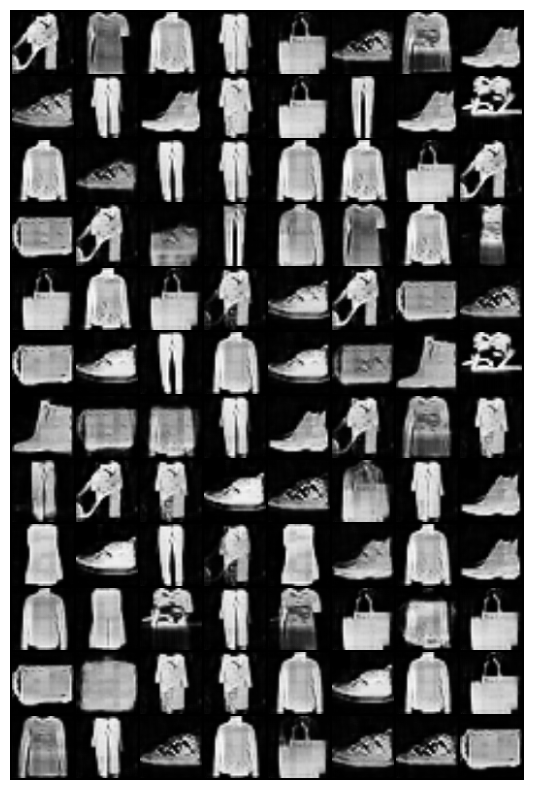

In [33]:
import torch

# Instantiate the generator model
generator = Generator(noise_channels, image_channels, gen_features)

# Load the saved state dictionary
generator.load_state_dict(torch.load('generator.pth', map_location=torch.device('cpu')))  # Load onto CPU

# Move the generator model to the appropriate device (GPU)
generator.to(device)

# Set the generator model to evaluation mode
generator.eval()

# Generate fake images
with torch.no_grad():
    fixed_noise = torch.randn(batch_size, noise_channels, 1, 1).to(device)
    fake_images = generator(fixed_noise)

# Now fake_images contains the generated fake images
import matplotlib.pyplot as plt
import torchvision.utils

# Convert the fake images to a grid
fake_images_grid = torchvision.utils.make_grid(fake_images.cpu(), nrow=8, normalize=True)

# Convert the PyTorch tensor to a NumPy array and transpose the dimensions
fake_images_grid_np = fake_images_grid.permute(1, 2, 0).numpy()

# Display the fake images grid using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(fake_images_grid_np)
plt.axis('off')
plt.show()
